# Data Preparation

## The problem

We look for the set of records which pair the atributes of the path/channel. to be precise:
* hop_lengths [km] - Length of the edge; natural number
* number_of_paths_in_hops [/] - Number of channels in the edge; natural number
* hop_losses [db] - Description of edge suppression; real number
* number_od_hops [/] - Number of edges of which the path consists; natural number
* transponder_modulation [class] - Description of transponder modulation at the beginning and end of the path; string
* transponder_bitrate [Gbps] - Description of the transmission rate of the transponder; natural number

with the channels/paths OSNR (Optical Signal to Noise Ratio) which defines Quality of Transmission (QoT).

## Topological map

### Baseline SNDlib
The map is imported via XML format provided by SNDLib. The code is generic and works with any provided model type file from the database. Converts the file provided into the graph structure based on Node, Link and Demand objects.

In [1]:
from xml.dom import minidom
import numpy as np
import math
from math import sin, cos, sqrt, atan2, radians, log
import random
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import pandas as pd

In [2]:
FILE = "janos-us-ca.xml"
Read_Data = minidom.parse(FILE)

In [3]:
nodelist = Read_Data.getElementsByTagName("node")


class Node:
    def __init__(self, uid, x, y):
        self.uid = uid
        self.x = x
        self.y = y
        self.linklist = []
        self.demandlist = []


class Link:
    def __init__(self, uid, source, target, capacity):
        self.uid = uid
        self.source = source
        self.target = target
        self.capacity = capacity


class Demand:
    def __init__(self, uid, source, destination, demandValue):
        self.uid = uid
        self.source = source
        self.destination = destination
        self.demandValue = demandValue


nodemap = {}

for node in nodelist:
    if node.hasAttribute("id"):
        Nodeid = node.getAttribute("id")
    xCoordinates = node.getElementsByTagName('x')[0]
    yCoordinates = node.getElementsByTagName('y')[0]
    nodemap[Nodeid] = Node(Nodeid, xCoordinates.firstChild.data, yCoordinates.firstChild.data)
    print("%s : %s %s" % (node.getAttribute("id"), xCoordinates.firstChild.data, yCoordinates.firstChild.data))

linklist = Read_Data.getElementsByTagName("link")
for link in linklist:
    if link.hasAttribute("id"):
        Linkid = link.getAttribute("id")
    Source = link.getElementsByTagName('source')[0]
    Destination = link.getElementsByTagName('target')[0]
    Capacity = link.getElementsByTagName('capacity')[0]
    linkobj = Link(Linkid, Source.firstChild.data, Destination.firstChild.data, Capacity.firstChild.data)
    if Source.firstChild.data in nodemap:
        nodemap[Source.firstChild.data].linklist.append(linkobj)
    # THE EDGES ARE DIRECTED
#     if Destination.firstChild.data in nodemap:
#         nodemap[Destination.firstChild.data].linklist.append(linkobj)

    print("%s - %s to %s: %s" % (link.getAttribute("id"), Source.firstChild.data, Destination.firstChild.data, Capacity.firstChild.data))

demandlist = Read_Data.getElementsByTagName("demand")
for demand in demandlist:
    if demand.hasAttribute("id"):
        Demandid = demand.getAttribute("id")
    Source = demand.getElementsByTagName('source')[0]
    Destination = demand.getElementsByTagName('target')[0]
    Demandval = demand.getElementsByTagName('demandValue')[0]
    demandobj = Demand(Demandid, Source.firstChild.data, Destination.firstChild.data, Demandval.firstChild.data)
    if Source.firstChild.data in nodemap:
        nodemap[Source.firstChild.data].demandlist.append(demandobj)
    if Destination.firstChild.data in nodemap:
        nodemap[Destination.firstChild.data].demandlist.append(demandobj)

    print("%s needs %s" % (demand.getAttribute("id"), Demandval.firstChild.data))

Vancouver : -123.1 49.22
LosAngeles : -118.4 33.93
SanFrancisco : -122.38 37.62
LasVegas : -115.17 36.08
SaltLakeCity : -111.97 40.78
ElPaso : -106.4 31.8
Dallas : -96.85 32.85
Houston : -95.35 29.97
OklahomaCity : -95.9 36.2
Minneapolis : -93.38 45.07
KansasCity : -94.72 39.32
Denver : -104.87 39.75
Chicago : -87.9 41.98
Indianapolis : -86.27 39.65
Detroit : -83.02 42.42
StLouis : -90.37 38.75
Nashville : -86.68 36.12
Cleveland : -81.68 41.52
NewYork : -73.78 40.65
Montreal : -73.6 45.5
Charlotte : -80.93 35.22
NewOrleans : -90.02 29.83
Boston : -71.03 42.37
Atlanta : -84.42 33.65
Miami : -80.28 25.82
WashingtonDC : -77.04 38.85
Philadelphia : -75.13 40.0
Toronto : -79.41 43.7
Pittsburgh : -79.97 40.44
Cincinnati : -84.5 39.14
Tampa : -82.48 27.96
Memphis : -90.0 35.11
Winnipeg : -97.16 49.88
Calgary : -114.08 51.08
Seattle : -122.3 47.45
Portland : -122.65 45.53
Sacrameto : -121.46 38.56
Phoenix : -112.02 33.43
SanDiego : -117.13 32.81
L0 - Vancouver to Calgary: 1008.0
L1 - Vancouver

In [4]:
[[link.source, link.target] for link in nodemap['Vancouver'].linklist]

[['Vancouver', 'Calgary'], ['Vancouver', 'Seattle']]

### Updating atributes

#### Type refinement

SNDlib parsing leaves us with crucial arguments defined as string type.

In [5]:
for node_name in nodemap.keys():
    nodemap[node_name].x = float(nodemap[node_name].x)
    nodemap[node_name].y = float(nodemap[node_name].y)

#### Distance calculation

Each Link object is having it's distance parameter added based on the geolocations of the vortexes connected by it. The distance is in kilometers.

In [6]:
# Approximate radius of earth in km
R = 6373.0

def approx_distance(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [7]:
for node_name in nodemap.keys():
    for link_iter in range(len(nodemap[node_name].linklist)):
        link = nodemap[node_name].linklist[link_iter]
        other_city = link.source if link.source != node_name else link.target
        distance = approx_distance(nodemap[node_name].x, nodemap[node_name].y, nodemap[other_city].x, nodemap[other_city].y)
        nodemap[node_name].linklist[link_iter].distance = distance

## Generating Data
Each datapoint represents a channel. The channel is here defined, as a specific path between two distinct nodes. For each channel:
* hop_len = $\sum{channel.links.distance }$ - the sum of lengths defined in links on the channel
* number_of_hops = $|channel.links|$ - number of the links on the channels way
* number_of_paths_in_hops = $| channels.links \cap channel.link |$ - number of channels at least one the same edge
* hop_losses = $ rand(\beta(2, 8) * 25 + 12) $ - the channel supression drawn from the $\beta$ distribution
* transponder_modulation = $\{QPSK, 8QAM, 16QAM, 32QAM\}$
* transponder_bitrate = $\{100, 200, 400\}$

The target variable is then counted within:
$$
OSNR = 159 + P_0 - \Gamma - 10logN - 10logBr - NF
$$

Where:
* $P_0$ is an input power (default: random from range of (10, 20) dB)
* $\Gamma$ is an average of the hop losses (calculated automatically based on Path)
* $N$ is number of spans (calculated automatically based on Path)
* $NF$ is a Noise Figure of the amplifiers (default: 5 dB)
* $Br$ is optical measurment bandwith (default: 12 500 Hz)

We will be handling data in tabular form using pandas.

### Look-up distributions

#### Beta distribution
Used in counting hop losses

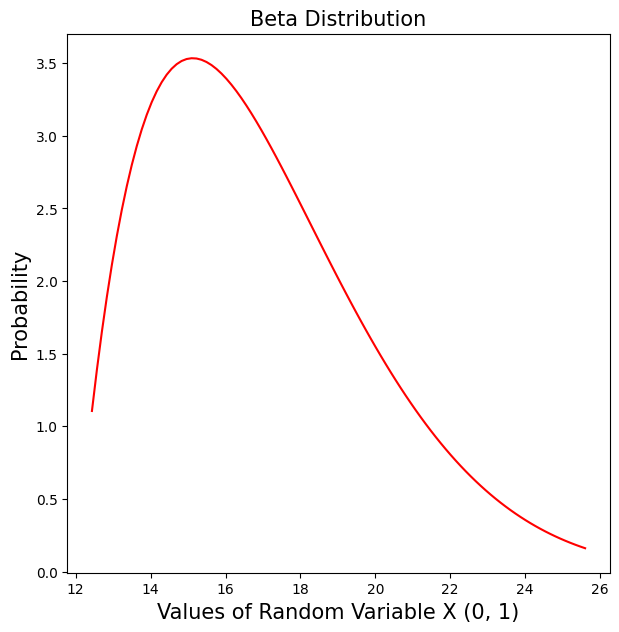

In [8]:
a, b = 2, 8
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
plt.figure(figsize=(7,7))
# plt.xlim(0.7, 1)
plt.plot(12 + x*25, beta.pdf(x, a, b), 'r-')
plt.title('Beta Distribution', fontsize='15')
plt.xlabel('Values of Random Variable X (0, 1)', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

#### Normal distribution
Used in counting paths per vortex

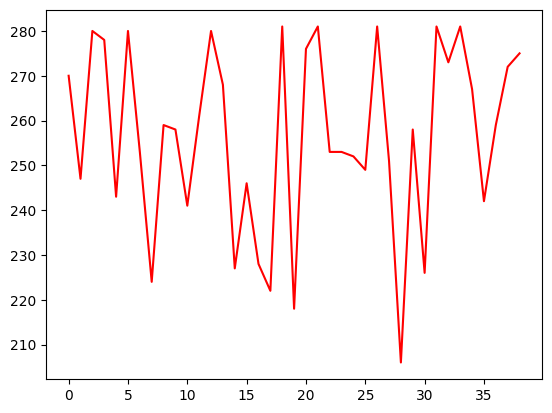

In [9]:
K = 10000
x = norm.rvs(K//len(nodemap.keys()), K//len(nodemap.keys()) * 0.1, size=len(nodemap.keys()))
x = [round(xi) for xi in x]
while K != sum(x):
    if  K > sum(x):
        print(K - sum(x))
        idx = x.index(min(x))
        x[idx] = x[idx] + 1
    else:
        idx = x.index(max(x))
        x[idx] = x[idx] - 1
plt.plot(range(len(x)), x, 'r-')
plt.show()

#### Half-normal distribution
Used in counting distance budget.

(array([0.10048573, 0.10605199, 0.11396195, 0.10077869, 0.09198985,
        0.10253645, 0.11044641, 0.09667723, 0.10810272, 0.08818135,
        0.10312238, 0.08759543, 0.09638427, 0.08320101, 0.08349397,
        0.07616994, 0.07997843, 0.08056436, 0.07880659, 0.07031071,
        0.06503741, 0.06650221, 0.06591629, 0.06474445, 0.05536969,
        0.05536969, 0.04951046, 0.05097527, 0.04628789, 0.04716677,
        0.04130754, 0.03515536, 0.03339759, 0.03808497, 0.0325187 ,
        0.02841725, 0.02490171, 0.02783132, 0.02548763, 0.02138617,
        0.02226506, 0.01669879, 0.01787064, 0.01523399, 0.01259734,
        0.01083957, 0.00966772, 0.01113253, 0.00585923, 0.00790996,
        0.00556626, 0.00644515, 0.00673811, 0.00556626, 0.00556626,
        0.0052733 , 0.00292961, 0.00439442, 0.0038085 , 0.00322257,
        0.00234369, 0.00117185, 0.00205073, 0.00117185, 0.00175777,
        0.00087888, 0.00175777, 0.00029296, 0.00087888, 0.00087888,
        0.00029296, 0.00029296, 0.00029296, 0.00

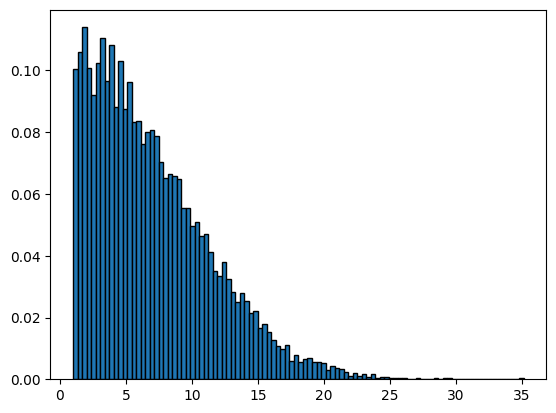

In [10]:
x = norm.rvs(1, 7.5, size=10000)
x = [xi + 1 if xi > 0 else -1 * xi + 1 for xi in x]
plt.hist(x, density=True, edgecolor='black', bins=100)

### Generate Paths
Problem:
_Given graph, generate k non-overlapping acyclic paths_
Solution:
```.txt
amount of paths begining in each vortex (budget K) ~ N(K/no_vortex, V_STD * K/no_vortex)
dist ~ +N(DIST_MEAN, DIST_STD)
for v in Vortex:
    for i in range(amount of paths in v):
        d = random(dist)
        path_vi = DFS(max_depth = d)
```

In [11]:
V_STD = 0.1
DIST_MEAN = 1
DIST_STD = 7.5
K = 10000

In [12]:
def amount_of_paths_per_vortex(no_vortex, std_param, budget):
    x = norm.rvs(budget//no_vortex, budget//no_vortex * std_param, size=no_vortex)
    x = [round(xi) for xi in x]
    while budget != sum(x):
        if  budget > sum(x):
            idx = x.index(min(x))
            x[idx] = x[idx] + 1
        else:
            idx = x.index(max(x))
            x[idx] = x[idx] - 1
    return x

In [13]:
def DFS(max_hops, start, nodemap):
    visited = {}
    for k in nodemap.keys():
        visited[k] = 0
    
    path = []
    no_choice_left = False
    current_node = start
    
    while len(path) < max_hops and not no_choice_left:
        visited[current_node] = True
        current_links = nodemap[current_node].linklist
        availible_links = []
        for c in current_links:
            if not visited[c.target]:
                availible_links.append(c)
        if len(availible_links) == 0:
            no_choice_left = True
        else:
            path.append(random.choice(availible_links))
            current_node = path[-1].target
        
    return path

In [14]:
paths = []
i = 0
x = amount_of_paths_per_vortex(len(nodemap.keys()), V_STD, K)
for v_start in nodemap.keys():
    max_hops = norm.rvs(DIST_MEAN, DIST_STD, size=x[i])
    max_hops = [int(xi) + 1 if xi > 0 else -1 * int(xi) + 1 for xi in max_hops]
    for max_hop in max_hops:
        paths.append(DFS(max_hop, v_start, nodemap))
    i = i + 1

### Analyze Paths

In [15]:
SPAN_LENGTH = 70
BETA_A = 2
BETA_B = 8
BETA_PARAM = 25
BETA_CONST = 12
# hop_loss = \Beta(BETA_A, BETA_B) * BETA_PARAM + BETA_CONST
P0_MIN = 10
P0_MAX = 20
# p0 = random(P0_MIN, P0_MAX)
NF = 5
BR = 12500

In [16]:
class Path:
    def __init__(self, raut : list) -> None:
        # Given data
        self.start = raut[0].source
        self.finish = raut[-1].target
        self.raut = raut # [Links]

        # Counted data
        self.hop_len = sum([l.distance for l in raut])
        self.number_of_hops = max(self.hop_len // 70 - len(raut) + 1, 1) # amplifiers - vortexes
        self.hop_losses = BETA_CONST + beta.rvs(BETA_A, BETA_B, size=10) * BETA_PARAM
        self.transponder_modulation = random.choice(['QPSK', '8QAM', '16QAM', '32QAM'])
        self.transponder_bitrate = random.choice([100, 200, 400])

        # OSNR calculations
        self.p0 = random.random() * (P0_MAX - P0_MIN) + P0_MIN
        self.gamma = np.average(self.hop_losses)
        self.n = self.number_of_hops
        self.nf = NF
        self.br = BR
        self.osnr = self.get_osnr()
    
    def get_osnr(self, p0=None, gamma=None, n=None, nf=None, br=None):
        self.p0 = p0 if p0 else self.p0
        self.gamma = gamma if gamma else self.gamma
        self.n = n if n else self.n
        self.nf = nf if nf else self.nf
        self.br = br if br else self.br
        self.osnr = 159 + self.p0 - self.gamma - 10 * log(self.n) - 10 * log(self.br) - self.nf
        return self.osnr

    def describe_metadata(self):
        return ['hop_len', 'no_of_hops', 'avg_hop_loss', 'transponder_modulation', 'transponder_bitrate', 'OSNR']
    
    def describe(self):
        return [self.hop_len, self.number_of_hops, np.average(self.hop_losses), self.transponder_modulation, self.transponder_bitrate, self.osnr]
    
    def full_describe_metadata(self):
        return ['start', 'finish', 'hop_len', 'no_of_hops', 'avg_hop_loss', 'transponder_modulation', 'transponder_bitrate', 'P0', 'Gamma', 'N', 'NF', 'BR', 'OSNR']
    
    def full_describe(self):
        return [self.start, self.finish, self.hop_len, self.number_of_hops, np.average(self.hop_losses), self.transponder_modulation, self.transponder_bitrate, self.p0, self.gamma, self.n, self.nf, self.br, self.osnr]

In [17]:
pd.DataFrame([len(p) for p in paths]).value_counts()

4     1117
3     1088
2     1076
5     1029
1      985
6      782
7      770
8      699
9      562
10     469
11     400
12     286
13     226
14     137
15     115
16      89
17      59
18      47
19      28
20      12
21       8
22       8
24       4
23       2
25       1
27       1
dtype: int64

In [18]:
paths = [Path(raut) for raut in paths]

### Turn paths into data

In [19]:
data = pd.DataFrame([p.describe() for p in paths], columns=paths[0].describe_metadata())
data_full = pd.DataFrame([p.full_describe() for p in paths], columns=paths[0].full_describe_metadata())

In [21]:
f = f'./data/data_{FILE}.csv'
data.to_csv(f)

In [22]:
f = f'./data/full_data_{FILE}.csv'
data_full.to_csv(f)